# Bayesian Inference in Visual-SB1 Systems
### Information and Decision Systems Group<br>University of Chile

Example of Bayesian inference in visual-SB1 systems incorporating a Gaussian prior on the parallax $\pi$.

In [1]:
import sys
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm.notebook import tqdm
from cmdstanpy import CmdStanModel
sys.path.append( '../src' )
from utils import read_in3, getOrbit, getRVSingle

## 1. Observations

In [2]:
system = 'HIP109951'

### 1.1. Data Parsing

In [3]:
df_as, df_v1, df_v2, df_priors = read_in3('./data/{}.in3'.format(system))
print('Astrometric observations:')
display(df_as)
print('V1 observations:')
display(df_v1)
print('Priors:')
display(df_priors)

Astrometric observations:


,epoch,X,Y,X_err,Y_err
0,1991.2500,0.160381,-0.081718,0.010,0.010
1,1999.8152,0.099174,0.280059,0.005,0.005
2,2000.7672,0.087761,0.296275,0.005,0.005
3,2000.8726,0.075238,0.301762,0.005,0.005
4,2003.6368,0.015605,0.343646,0.005,0.005
5,2004.8152,-0.015572,0.356660,0.005,0.005
6,2006.5173,-0.055926,0.369795,0.005,0.005
7,2006.5174,-0.049039,0.362700,0.005,0.005
8,2007.8171,-0.090709,0.372103,0.005,0.005
9,2007.8199,-0.093929,0.379550,0.005,0.005


V1 observations:


,epoch,RV,err
0,1987.527,-20.42,0.34
1,1988.480,-20.41,0.68
2,1988.592,-21.87,0.84
3,1989.460,-21.39,0.49
4,1990.533,-23.11,0.88
5,1990.686,-21.12,0.72
6,1992.603,-24.55,0.81
7,1992.671,-23.40,0.59
8,1992.720,-22.40,0.65
9,1992.786,-21.76,0.58


Priors:


,param,mean,std
0,plx,0.01511764157,0.00053421
1,m1,0.95499258602,0.0146648601


### 1.2. Data Visualization

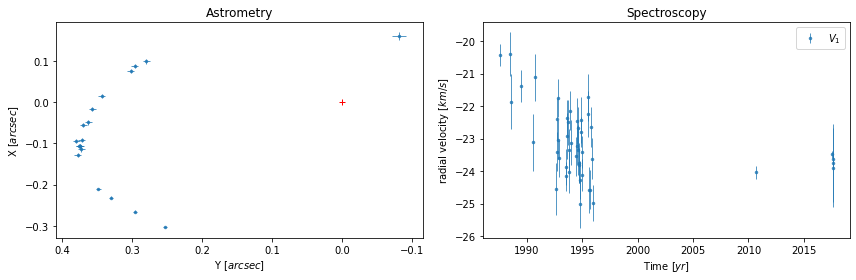

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.errorbar(df_as.Y, df_as.X, xerr=df_as.Y_err, yerr=df_as.X_err, fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.plot([0],[0],'+',color='r')
plt.xlabel(r'Y $[arcsec]$')
plt.ylabel(r'X $[arcsec]$')
plt.gca().invert_xaxis()
plt.title('Astrometry')
plt.subplot(1,2,2)
plt.errorbar(df_v1.epoch, df_v1.RV, yerr=df_v1.err, label=r'$V_1$', fmt='.', elinewidth=1, ms=5, alpha=0.75)
plt.ylabel(r'radial velocity [$km/s$]')
plt.xlabel('Time [$yr$]')
plt.title('Spectroscopy')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Bayesian Inference

### 2.1. Statistical Model

In [5]:
model = CmdStanModel(stan_file='../src/visual_sb1_priors.stan', user_header='../src/kepler_eq.hpp')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


functions {
    real kepler_eq(real M, real e);
    vector[] orbit(int N, vector t, real T, real P, real e, real a, real w, real Omega, real i) {
        // Variables declaration
        real M; real A; real B; real F; real G;
        vector[N] E; vector[N] x; vector[N] y; vector[N] pos[2];
        // Iterate over epochs
        for (j in 1:N) {
            // Mean anomaly
            M = 2 * pi() * (t[j] - T) / P;
            // Eccentric anomaly
            E[j] = kepler_eq(M, e);
        }
        // Auxiliary normalized coordinates
        x = cos(E) - e;
        y = sin(E) * sqrt(1 - e^2);
        // Thiele-Innes constants
        A = a * (cos(w) * cos(Omega) - sin(w) * sin(Omega) * cos(i));
        B = a * (cos(w) * sin(Omega) + sin(w) * cos(Omega) * cos(i));
        F = a * (-sin(w) * cos(Omega) - cos(w) * sin(Omega) * cos(i));
        G = a * (-sin(w) * sin(Omega) + cos(w) * cos(Omega) * cos(i));
        // Apparent orbit
        pos[1] = A * x + F * y;
        pos[2] = B * x +

In [6]:
# Orbital data
orbital_data = dict(N_as=len(df_as), 
                    N_v1=len(df_v1),
                    t_as=df_as.epoch.tolist(),
                    t_v1=df_v1.epoch.tolist(),
                    x_obs=df_as.X.tolist(),
                    y_obs=df_as.Y.tolist(),
                    x_err=df_as.X_err.tolist(),
                    y_err=df_as.Y_err.tolist(),
                    v1_obs=df_v1.RV.tolist(),
                    v1_err=df_v1.err.tolist(),
                    plx_obs=float(df_priors[df_priors['param']=='plx']['mean']), # Here we only impose a prior
                    plx_err=float(df_priors[df_priors['param']=='plx']['std']),  # on plx, not on m1.
                    m1_obs=0,   # m1_obs=0 dismisses the prior on m1.
                    m1_err=0)

### 2.2. Optimization Stage

In [7]:
# Initial guesses
V_mean = np.array(df_v1.RV.tolist() + df_v2.RV.tolist()).mean()
def init_func():
    return dict(T0=np.random.uniform(0, 1), 
                log_P=np.log(52), # Providing a previous estimate of P is highly recommended 
                                  # (e.g., from sb9 or orb6 catalogues).
                e=np.random.uniform(0, 1), 
                a=np.random.uniform(0, 1),
                w=np.random.uniform(0, 2*np.pi),
                Omega=np.random.uniform(0, 2*np.pi),
                i=np.random.uniform(0, np.pi),
                V0=np.random.uniform(V_mean-10, V_mean+10),
                plx=np.random.uniform(0, 10),
                q=np.random.uniform(0, 1))

# Maximum likelihood estimation
best_mle = dict(lp__=-np.inf)
for _ in tqdm(range(1000)):
    mle = model.optimize(data=orbital_data, inits=init_func(), require_converged=False).optimized_params_dict
    if mle['lp__'] > best_mle['lp__']:
        best_mle = mle
        print("Current maximum log-probability: {0:.4f}".format(best_mle['lp__']))

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing


Current maximum log-probability: -73512.4000
Current maximum log-probability: -88.0273


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/z26olb5p.json
init = /tmp/tmpaa3l1c8f/n7qjs2r0.json
random
  seed = 41139
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031912.csv
  diagnostic_file =  (Default

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/g3iiywxp.json
init = /tmp/tmpaa3l1c8f/yw8b8kja.j

Current maximum log-probability: -49.6929


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/d6qriu35.json
init = /tmp/tmpaa3l1c8f/qhodfm1_.json
random
  seed = 1034
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031914.csv
  diagnostic_file =  (Default)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/7t0btq0r.json
init = /tmp/tmpaa3l1c8f/gr79vex8.json
random
  seed = 8961
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-2022021

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

metho


method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/tr_rvegw.json
init = /tmp/tmpaa3l1c8f/xc747_z8.json
random
  seed = 83241
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031916.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -444717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -444717             0   1.18594e+06    0.000125       0.001       29   
Error evaluating model log proba

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        to

Current maximum log-probability: -49.6928


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/qr8q1ih5.json
init = /tmp/tmpaa3l1c8f/h0k3jlwv.j

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/vli0y0k9.json
init = /tmp/tmpaa3l1c8f/ql49s1l5.json
random
  seed = 70184
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031918.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -128584
    Iter      log prob        ||dx||      ||gra

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/bsvlcm5j.json
init = /tmp/tmpaa3l1c8f/zuc30j72.json
random
  seed = 6051
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031919.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -275595
    Iter      log prob        ||dx||      ||grad

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        to

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/6udi9hh7.json
init = /tmp/tmpaa3l1c8f/ejve9yo9.json
random
  seed = 32401
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031921.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = 

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/bq3buetd.json
init = /tmp/tmpaa3l1c8f/cpar54nl.json
random
  seed = 99512
output
  file = 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/acnmbpa8.json
init = /tmp/tmpaa3l1c8f/_gxtku0y.json
random
  seed = 16763
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-202202

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/ep6qh8xd.json
init = /tmp/tmpaa3l1c8f/6zhn1z79.json
random
  seed = 68036
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031923.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -73164.5
    Iter      log prob        ||dx||      ||gr

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        to

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_al

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Defau

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/28w5uk_k.json
init = /tmp/tmpaa3l1c8f/qhgfvgus.json
random
  seed = 76308
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031929.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Init

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/6zaagmwu.json
init = /tmp/tmpaa3l1c8f/drhcyync.json
random
  seed = 51403
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031930.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/a441c6bz.json
init = /tmp/tmpaa3l1c8f/5n_hplz9.json
random
  seed = 66533
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031931.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/1g8ojuu5.json
init = /tmp/tmpaa3l1c8f/smypq4hh.json
random
  seed = 73647
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-202202

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    sa

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/wc7pma_8.json
init = /tmp/tmpaa3l1c8f/3o8895pz.json
random
  seed = 31360
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031934.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -130731
    Iter      log prob        ||dx||      ||gra

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/bww08rtw.json
init = /tmp/tmpaa3l1c8f/s7qmhsmn.json
random
  seed = 79328
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031935.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = 


method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/_1nn0ft7.json
init = /tmp/tmpaa3l1c8f/s_6wto3_.json
random
  seed = 63034
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031936.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -397808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -397808            -0   1.08339e+06   0.0003203       0.001       37   
Error evaluating model log proba

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/hb1enwht.json
init = /tmp/tmpaa3l1c8f/y1qlaetn.j

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/zcf2wn0b.json
init = /tmp/tmpaa3l1c8f/lxudp848.json
random
  seed = 24812
output
  file = 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/uve7dcdz.json
init = /tmp/tmpaa3l1c8f/kpaqqj5s.json
random
  seed = 13478
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031940.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -71329.3
    Iter      log prob        ||dx||      ||gr

INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/f24jydld.json
init = /tmp/tmpaa3l1c8f/_k5zhgq9.json
random
  seed = 52775
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031941.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -219161
    It

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/7nkwnkkx.json
init = /tmp/tmpaa3l1c8f/na9m9gek.json
random
  seed = 23505
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031941.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -576885
    Iter      log prob        ||dx||      ||gra

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/0bozauyu.json
init = /tmp/tmpaa3l1c8f/1qwsnmmp.json
random
  seed = 77718
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031944.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Init


method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/e0ltq_e5.json
init = /tmp/tmpaa3l1c8f/6va2wugi.json
random
  seed = 28592
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031944.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -111148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -10966.6   0.000985221       2915.79   3.531e-07       0.001      142  LS failed, Hessian reset 
      73

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/8l2tsn0o.json
init = /tmp/tmpaa3l1c8f/qbnq1_7t.j

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/16sg8_ow.json
init = /tmp/tmpaa3l1c8f/x2hn_abw.json
random
  seed = 86139
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031946.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = 

INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpaa3l1c8f/a1i62f09.json
init = /tmp/tmpaa3l1c8f/rs450nj6.json
random
  seed = 38390
output
  file = /tmp/tmpaa3l1c8f/visual_sb1_priors-20220212031947.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -79263.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

In [8]:
best_mle

OrderedDict([('lp__', -49.6928),
             ('T0', 0.0474355),
             ('log_P', 4.01613),
             ('e', 0.404122),
             ('a', 0.307547),
             ('w', 0.977363),
             ('Omega', 4.57296),
             ('i', 0.479316),
             ('V0', -22.9241),
             ('f_plx', 21.6499),
             ('q', 0.48655),
             ('P', 55.486),
             ('plx', 0.0151179),
             ('m1', 1.83956),
             ('w_deg', 55.9988),
             ('Omega_deg', 262.011),
             ('i_deg', 27.4628),
             ('T', 1990.16),
             ('m2', 0.895036),
             ('plx_mas', 15.1179)])

### 2.3. Inference Stage

In [9]:
# MCMC Sampling
fit = model.sample(data=orbital_data, iter_warmup=2500, iter_sampling=2500, inits=best_mle)
fit.summary()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-60.000,0.044000,2.30000,-64.000,-60.000,-57.000,2800.0,30.0,1.0
T0,0.047,0.000085,0.00440,0.040,0.047,0.054,2700.0,28.0,1.0
log_P,4.000,0.001500,0.05500,3.900,4.000,4.100,1400.0,14.0,1.0
e,0.410,0.000490,0.02000,0.380,0.420,0.440,1600.0,17.0,1.0
a,0.300,0.000390,0.01400,0.290,0.300,0.330,1300.0,14.0,1.0
w,0.940,0.003100,0.12000,0.780,0.920,1.200,1400.0,15.0,1.0
Omega,4.600,0.000670,0.04500,4.500,4.600,4.600,4600.0,48.0,1.0
i,0.430,0.002600,0.09600,0.290,0.420,0.600,1400.0,14.0,1.0
V0,-23.000,0.002300,0.11000,-23.000,-23.000,-23.000,2200.0,23.0,1.0


## 3. Results

### 3.1. Variables Selection

In [10]:
df = fit.draws_pd()[['P', 'T', 'e', 'a', 'w_deg', 'Omega_deg', 'i_deg', 'V0', 'plx_mas', 'f_plx', 'm1', 'q', 
                     'lp__']]
# ------------Temporary!!!---------------
df['T'] = fit.draws_pd(vars=['T0']).to_numpy() * fit.draws_pd(vars=['P']).to_numpy() + np.min(df_as.epoch.tolist() + df_v1.epoch.tolist() + df_v2.epoch.tolist())
# ---------------------------------------
df.columns = [r'$P$ $[yr]$', r'$T$ $[yr]$', r'$e$', r'$a$ $[″]$', r'$\omega$ $[°]$',r'$\Omega$ $[°]$',
              r'$i$ $[°]$', r'$V_{0}$ $[km/s]$', r'$\pi$ $[mas]$', r'$f/\pi$ $[pc]$', r'$m_1$ $[M_\odot]$', 
              r'$q$', 'lp__']
df

,$P$ $[yr]$,$T$ $[yr]$,$e$,$a$ $[″]$,$\omega$ $[°]$,$\Omega$ $[°]$,$i$ $[°]$,$V_{0}$ $[km/s]$,$\pi$ $[mas]$,$f/\pi$ $[pc]$,$m_1$ $[M_\odot]$,$q$,lp__
0,51.8350,1989.818942,0.429491,0.290408,48.2781,260.953,16.8563,-23.0520,15.3661,31.9543,1.27876,0.964694,-60.7760
1,51.4988,1989.908047,0.434753,0.287677,47.0799,262.421,18.2965,-23.0856,14.7513,32.5806,1.45254,0.925321,-61.0681
2,51.7789,1989.671118,0.425652,0.288111,43.3389,265.370,17.1522,-23.0164,15.4453,29.6716,1.31146,0.845995,-60.0363
3,52.4332,1989.696356,0.428179,0.290979,44.6204,265.233,18.9290,-23.0014,14.8287,30.8162,1.49244,0.841494,-60.1266
4,51.5647,1989.595611,0.426618,0.288669,44.4444,263.966,17.0210,-23.0228,15.0471,28.0395,1.53509,0.729840,-59.5474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,56.4104,1990.415371,0.405638,0.316229,62.9570,258.093,31.1074,-22.7365,15.9397,23.5667,1.53208,0.601655,-62.4237
9996,57.1763,1990.465073,0.409296,0.310618,62.8309,258.427,27.8171,-22.6978,14.6124,23.5347,1.92777,0.524152,-65.3506
9997,55.8893,1990.278950,0.411922,0.312056,61.5071,257.876,30.7401,-22.6651,15.1422,24.1849,1.77590,0.577816,-66.9248
9998,59.7465,1990.073808,0.381028,0.317922,62.4865,261.911,29.2548,-22.8122,13.4432,25.7149,2.42444,0.528328,-68.7722


### 3.2. Point Estimates

In [11]:
# Samples
samples = df.drop(columns=['lp__']).to_numpy()
# MAP sample
map_sample = samples[df[['lp__']].to_numpy().argmax()]
# Uncertainty quantification
#lb = np.quantile(samples, 0.25, axis=0) # Quantile 1
#ub = np.quantile(samples, 0.75, axis=0) # Quantile 3
lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower
ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper

/tmp/ipykernel_20700/762135287.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  lb = az.hdi(samples, 0.95)[:,0] # 95% HPDI lower
/tmp/ipykernel_20700/762135287.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ub = az.hdi(samples, 0.95)[:,1] # 95% HPDI upper


In [12]:
# Summary table
summary_table = [[df.columns[i], 
                  r'${:.3f}_{{{:.3f}}}^{{{:.3f}}}$'.format(map_sample[i], lb[i], ub[i])] for i in range(len(map_sample))]
df_summary = pd.DataFrame(summary_table, columns=['Parameter', 'Estimate'])
df_summary

,Parameter,Estimate
0,$P$ $[yr]$,$55.003_{50.196}^{61.270}$
1,$T$ $[yr]$,$1990.116_{1989.513}^{1990.774}$
2,$e$,$0.407_{0.373}^{0.447}$
3,$a$ $[″]$,$0.305_{0.283}^{0.332}$
4,$\omega$ $[°]$,$54.827_{41.654}^{68.044}$
5,$\Omega$ $[°]$,$262.236_{257.100}^{267.248}$
6,$i$ $[°]$,$27.192_{15.240}^{35.133}$
7,$V_{0}$ $[km/s]$,$-22.884_{-23.154}^{-22.721}$
8,$\pi$ $[mas]$,$15.266_{14.045}^{16.112}$
9,$f/\pi$ $[pc]$,$22.386_{17.477}^{33.040}$


## 4. Visualization

### 4.1. Marginal Posterior Distributions

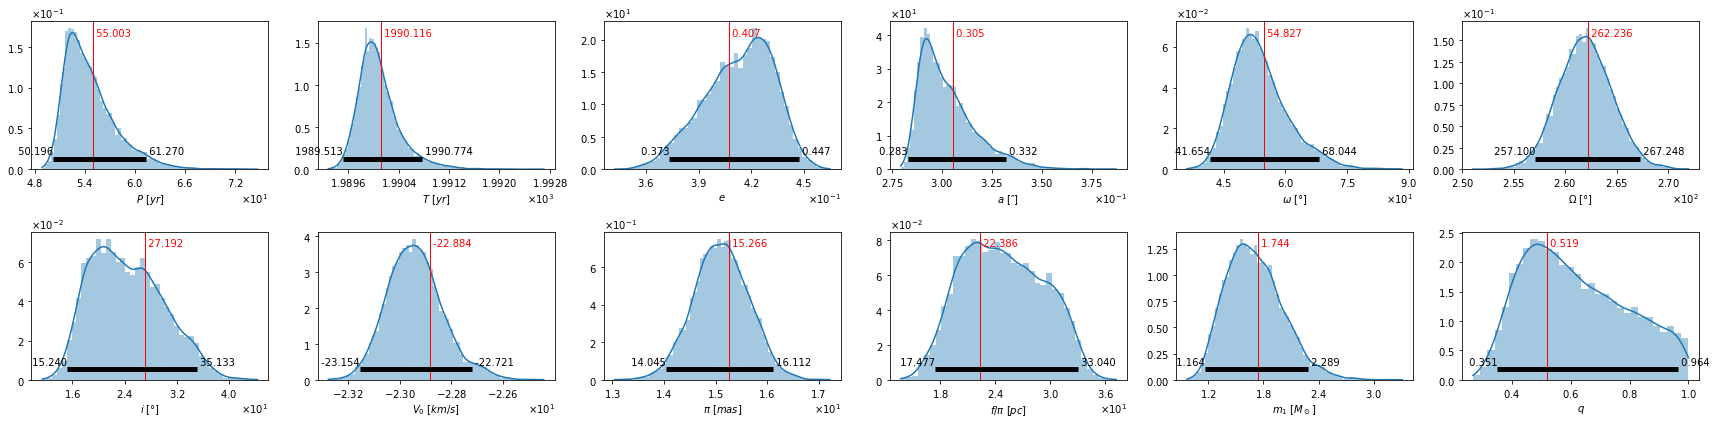

In [14]:
params_names = df.drop(columns=['lp__']).columns.tolist()
plt.figure(figsize=(24,6))
for i in range(samples.shape[1]):
    plt.subplot(2,6,i+1)
    sns.histplot(samples[:,i], stat='density', kde=True, color='tab:blue', alpha=0.4, **{"edgecolor": None})
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(map_sample[i], color='red', linewidth=1)
    plt.text(map_sample[i], max_ylim * 0.9, ' {:.3f}'.format(map_sample[i]), color='red')
    plt.hlines(y=max_ylim * 0.07, xmin=lb[i], xmax=ub[i], linewidth=5, color='black')
    plt.text(lb[i], max_ylim * 0.1, ' {:.3f}'.format(lb[i]), color='black', horizontalalignment='right') 
    plt.text(ub[i], max_ylim * 0.1, ' {:.3f}'.format(ub[i]), color='black') 
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel(params_names[i])
    plt.ylabel(None) 
plt.tight_layout()
plt.show()

### 4.2. Pair Posterior Distributions

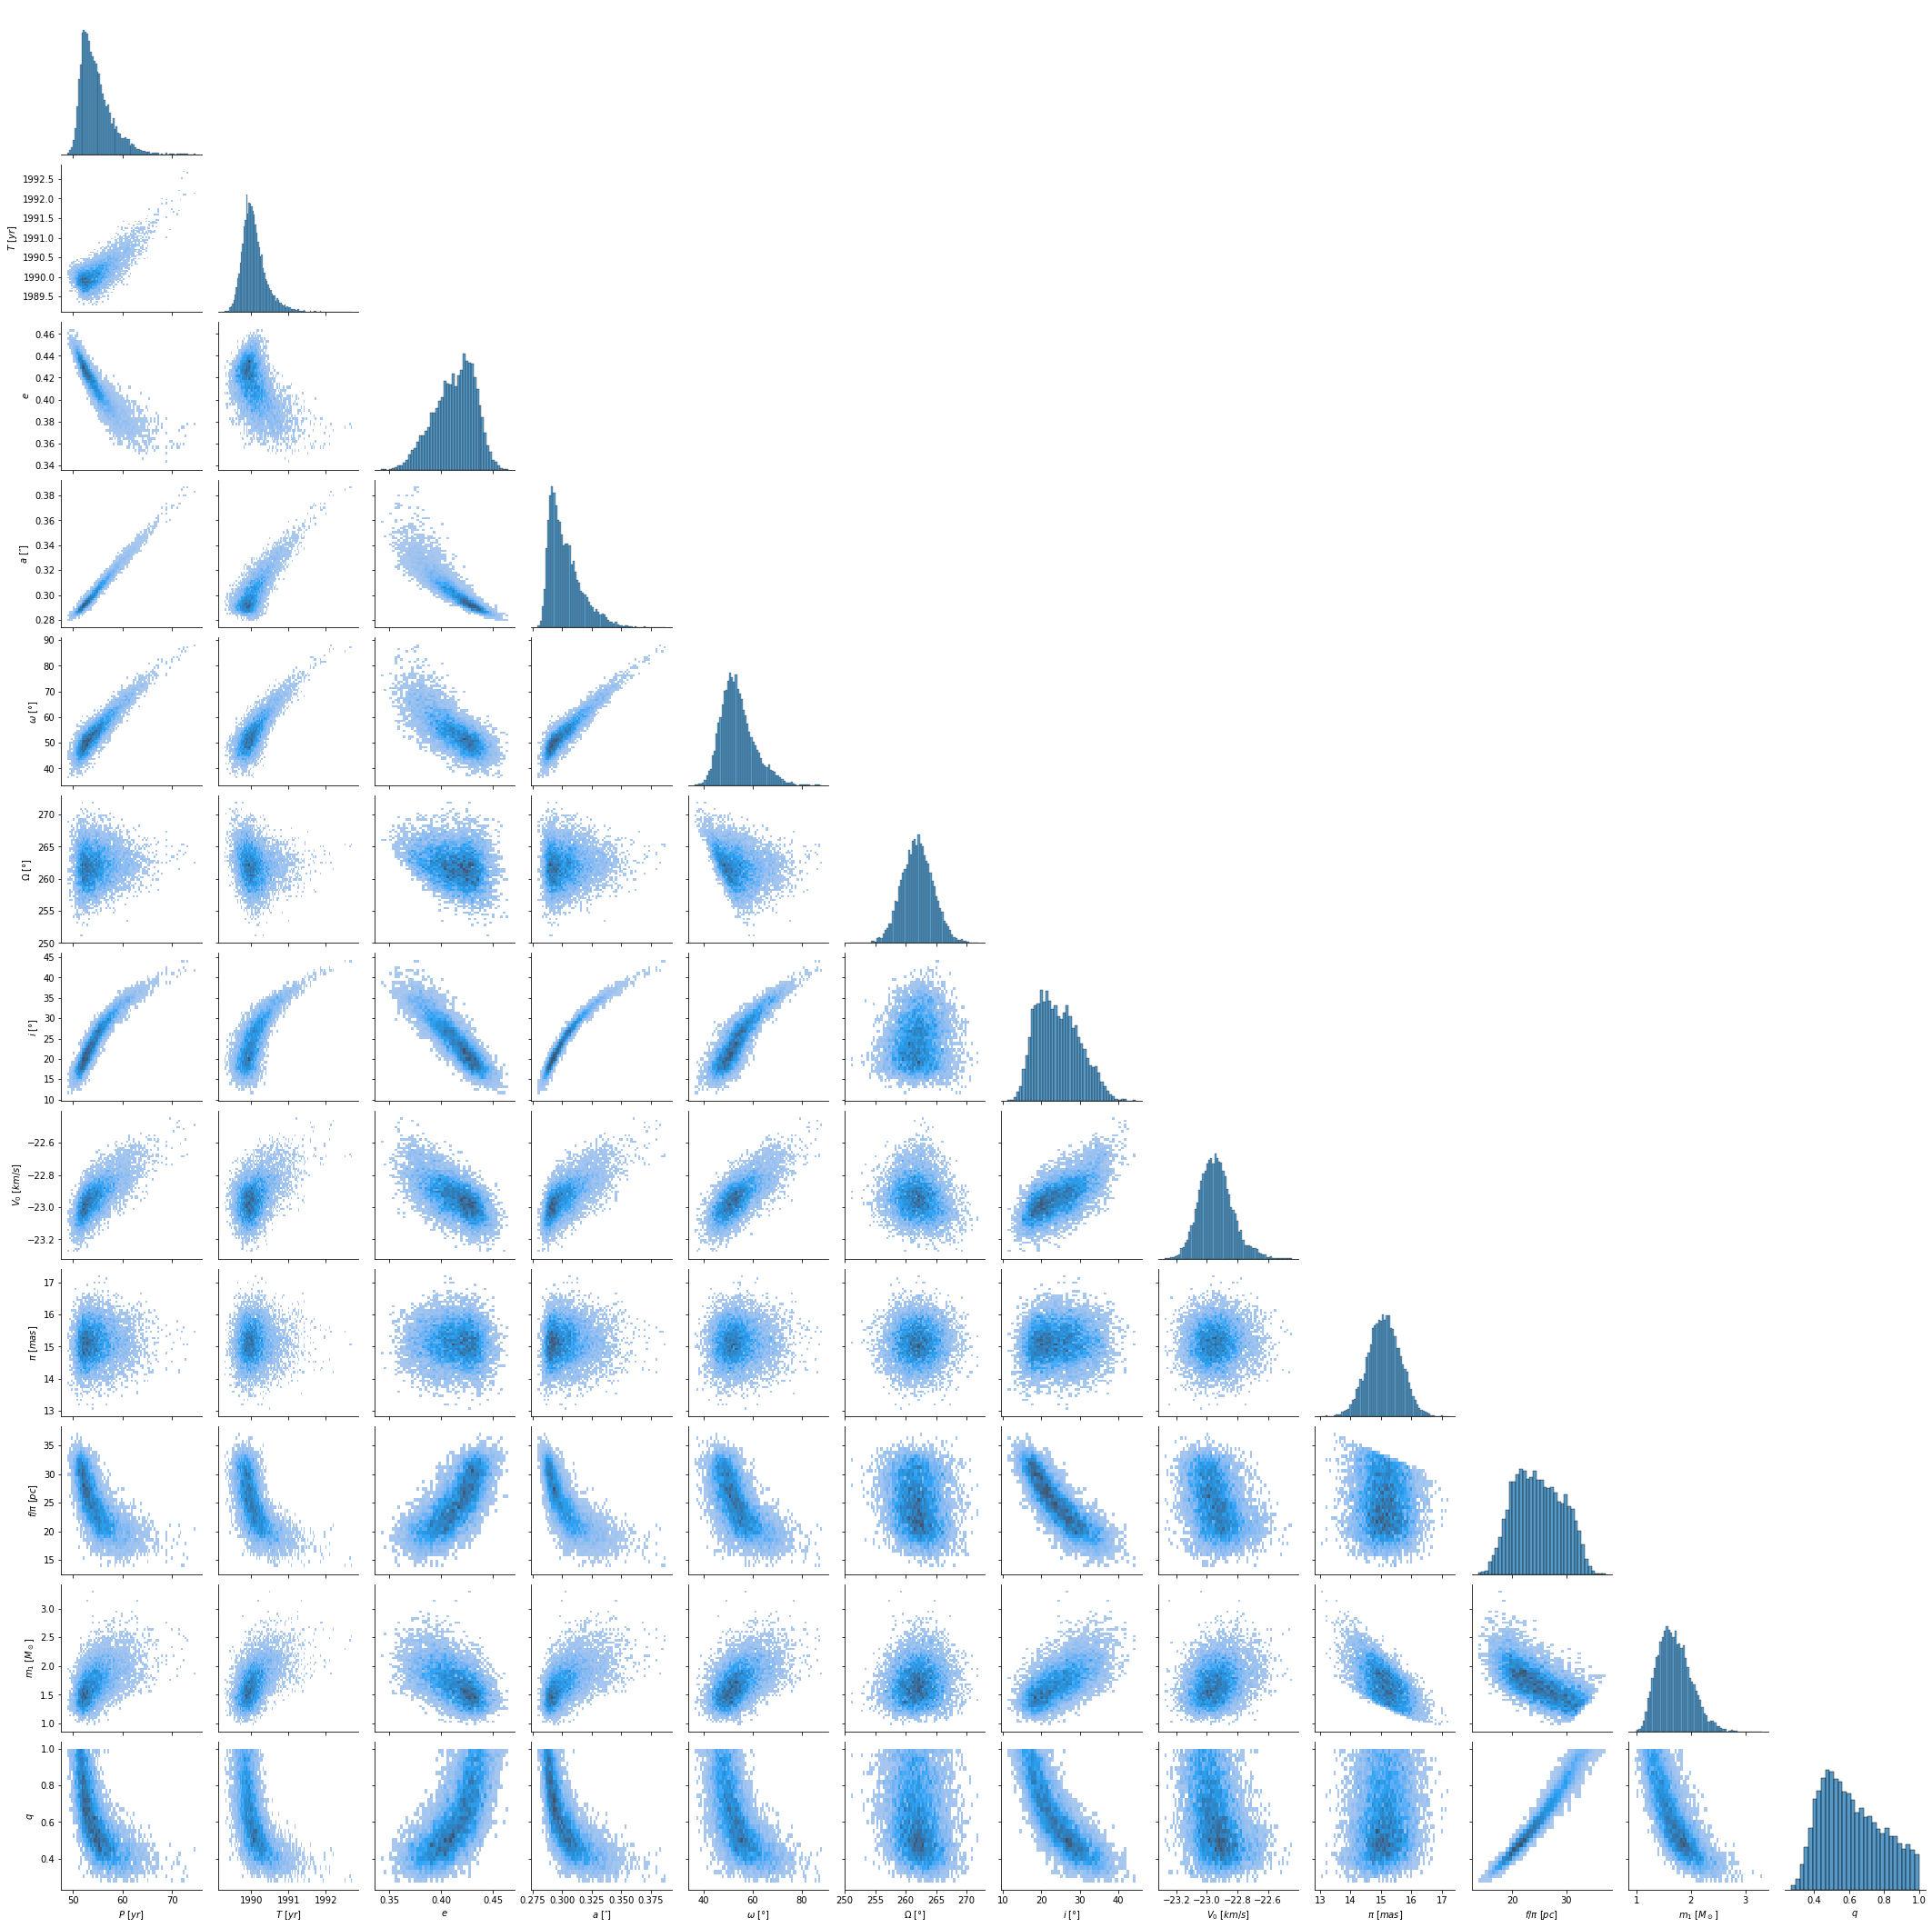

In [15]:
sns.pairplot(df.drop(columns='lp__'), kind='hist', corner=True)
plt.show()

### 4.3. Orbit & Radial Velocity Curve

In [16]:
# Aesthetics utils
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys_r')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

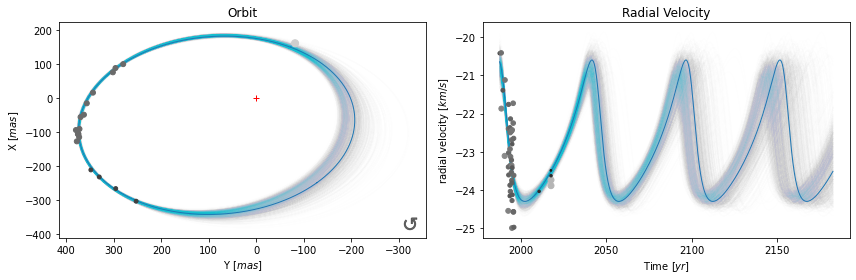

In [19]:
### Orbit & RV
plt.figure(figsize=(12,4))
rnd_idx = np.random.choice(samples.shape[0], 1000, replace=False)

### Orbit plot
plt.subplot(1, 2, 1)
# Orbit samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = samples[rnd_idx[j]]
    t = np.linspace(0, P, 1000)
    X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
    plt.plot(Y * 1000, X * 1000, color='tab:cyan', alpha=0.005)
# MAP orbit
P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = map_sample
t = np.linspace(0, P, 1000)
X, Y = getOrbit(t, T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
# Data projection on the MAP orbit
Xorb, Yorb = getOrbit(df_as.epoch.to_numpy(), T, P, e, a, np.deg2rad(w), np.deg2rad(Omega), np.deg2rad(i))
plt.plot(Y * 1000, X * 1000, color='tab:blue', linewidth=1, zorder=j)
for k in range(len(df_as)):
    plt.plot([df_as.Y[k]  * 1000, Yorb[k] * 1000], [df_as.X[k] * 1000, Xorb[k] * 1000], '--', color='blue', linewidth=0.5)
# Dataset
plt.scatter(df_as.Y * 1000, df_as.X * 1000, s=df_as.X_err * 5000, c=df_as.X_err, cmap=truncate_colormap(cmap, 0.2, 0.7), zorder=2000)
plt.plot([0], [0], '+', color='r')
legend = plt.gca().get_legend()
plt.xlabel(r'Y $[mas]$')
plt.ylabel(r'X $[mas]$')
plt.title('Orbit')
plt.gca().invert_xaxis()
# Orientation symbol: marker={r'$\circlearrowleft$', r'$\circlearrowright$'}
plt.plot([0.9 * plt.xlim()[1]],[0.9 * plt.ylim()[0]], marker=r'$\circlearrowleft$',ms=15, mew=0.5, color='black', alpha=0.6)

### RV plot
plt.subplot(1, 2, 2)
t = np.linspace(df_v1.epoch.min(), df_v1.epoch.max() + 3*P, 1000)
# RV samples
for j in tqdm(range(1000)):
    P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = samples[rnd_idx[j]]
    V1 = getRVSingle(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, f_plx)
    plt.plot(t, V1, color='tab:cyan', alpha=0.005)
# MAP RV
P, T, e, a, w, Omega, i, V0, plx, f_plx, m1, q = map_sample
V1 = getRVSingle(t, T, P, e, a, np.deg2rad(w), np.deg2rad(i), V0, f_plx)
plt.plot(t, V1, linewidth=1, color='tab:blue')    
plt.scatter(df_v1.epoch, df_v1.RV, s=df_v1.err * 30, c=df_v1.err, cmap=truncate_colormap(cmap, 0.1, 0.6), zorder=2000)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('radial velocity [$km/s$]')
plt.xlabel('Time $[yr]$')
plt.title('Radial Velocity')

plt.tight_layout()
plt.show()